In [4]:
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Cargamos el modelo preentrenado (en lugar de entrenar el modelo durante más de 1 hora)
with open('resnet-50-MRI.json', 'r') as json_file:
    json_savedModel = json_file.read()

# Cargar el modelo
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('weights.hdf5')
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

# Función para cargar y preprocesar imágenes de prueba utilizando ImageDataGenerator
def image_generator(dataframe, batch_size=32, target_size=(256, 256)):
    data_generator = ImageDataGenerator(rescale=1./255)  # Normalizar los valores de píxeles entre 0 y 1
    generator = data_generator.flow_from_dataframe(
        dataframe=dataframe,
        x_col='image_path',  # Columna que contiene las rutas de las imágenes
        y_col=None,  # No hay etiquetas de salida para la predicción
        batch_size=batch_size,
        target_size=target_size,
        class_mode=None,  # Sin etiquetas de clase
        shuffle=False  # No se requiere mezcla de los datos de prueba
    )
    return generator

# Ejemplo de uso:
test_mask = pd.read_csv('test_mask.csv')  # Tu conjunto de datos de prueba (pandas DataFrame) que contiene la columna 'image_path'
test_batch_size = 32

# Obtener el generador de imágenes de prueba utilizando la función image_generator
test_generator = image_generator(test_mask, batch_size=test_batch_size)

# Realizar predicciones
test_predict = model.predict(test_generator, steps=len(test_generator), verbose=1)


Found 20 validated image filenames.
1/1 [==============================] - 3s 3s/step


In [5]:
# Obtenemos la clase predicha a partir del modelo
predict = []

for i in test_predict:
  predict.append(str(np.argmax(i)))

predict = np.asarray(predict)

In [6]:
predict

array(['1', '0', '0', '1', '1', '0', '1', '1', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0'], dtype='<U1')

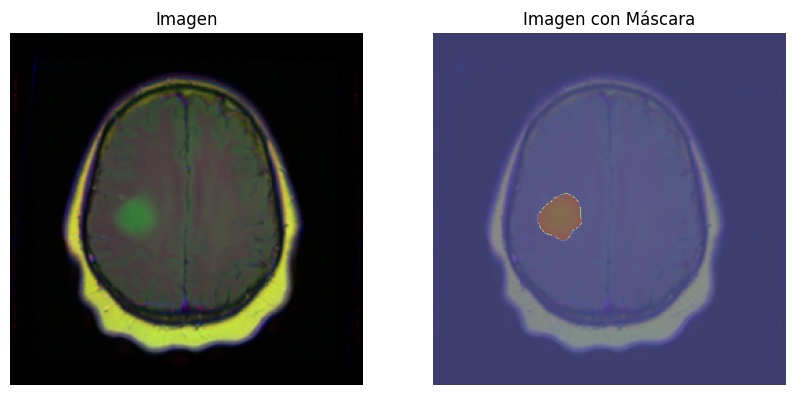

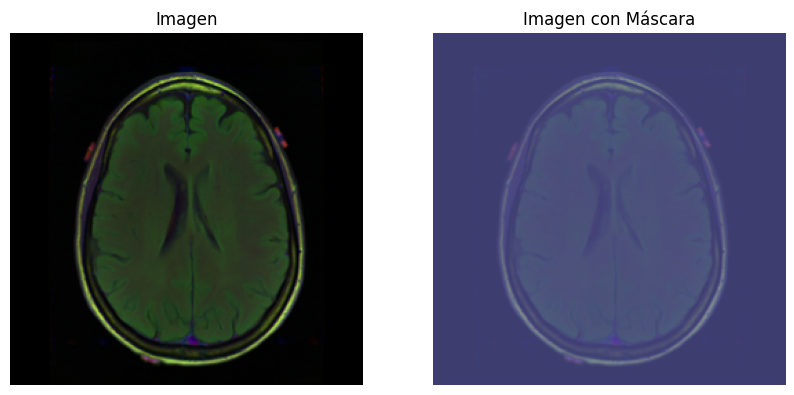

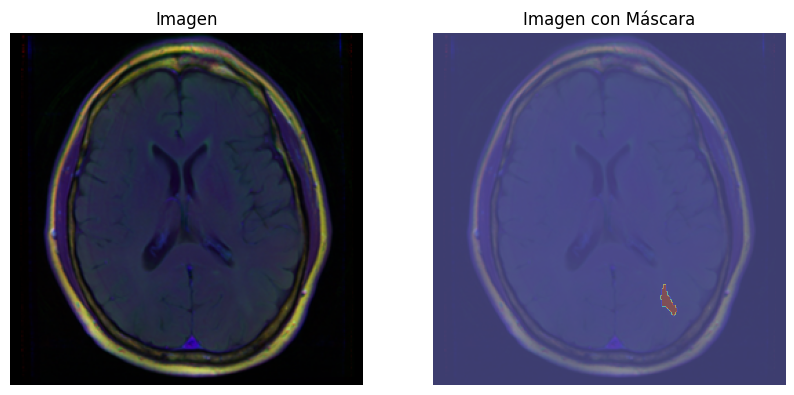

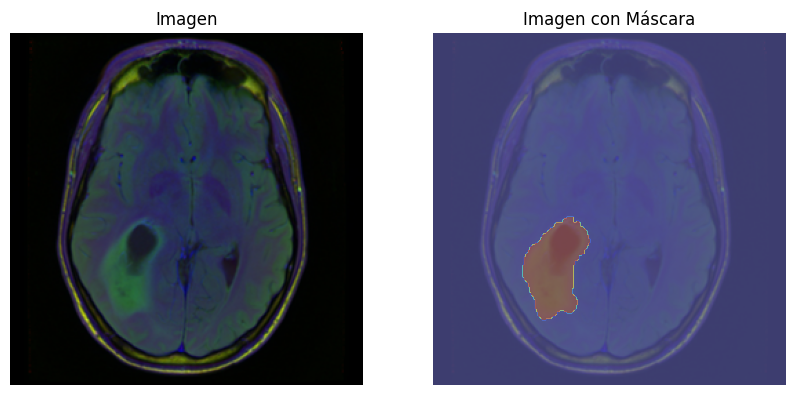

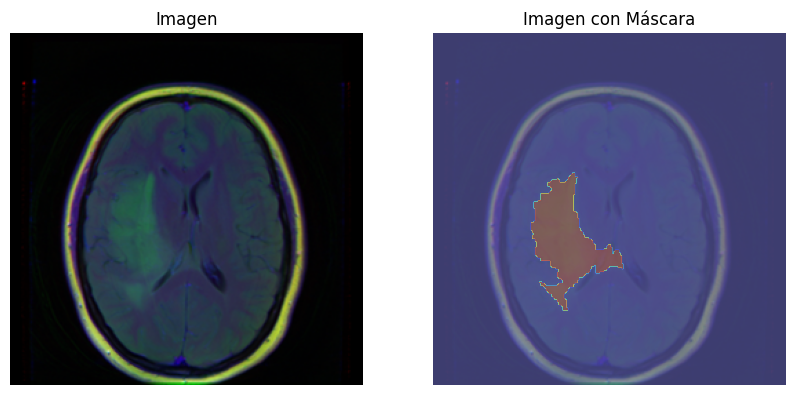

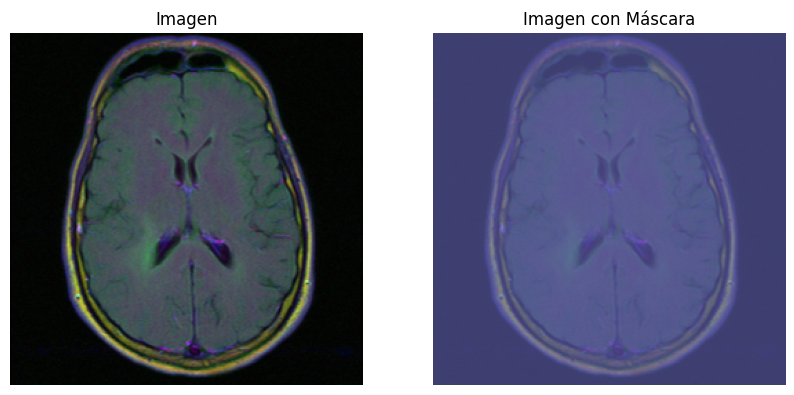

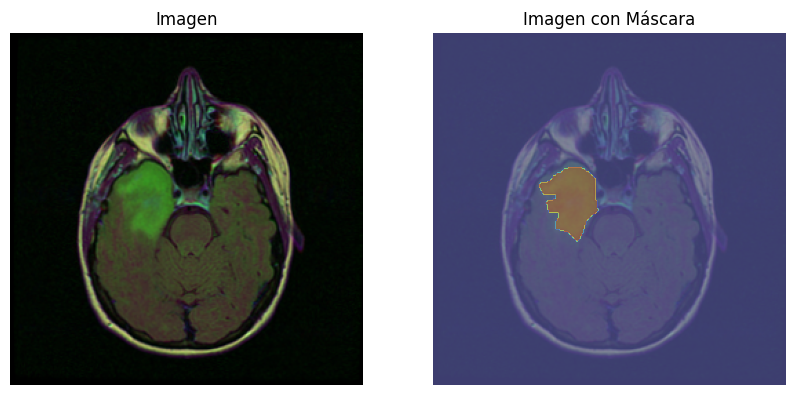

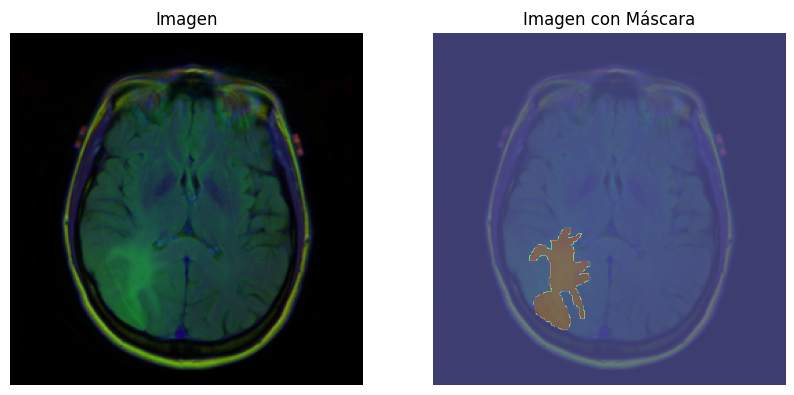

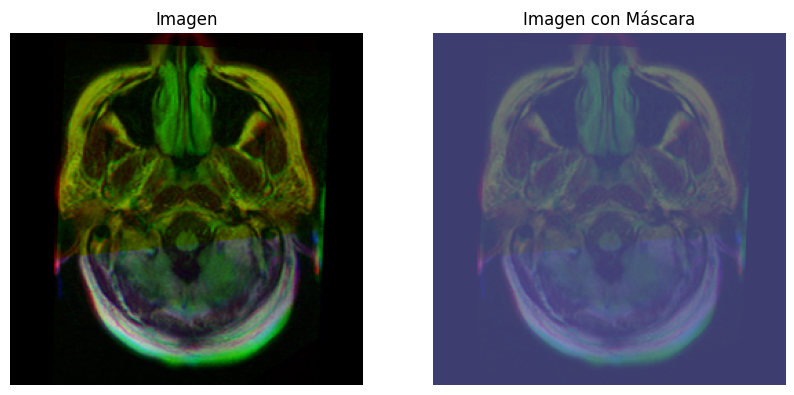

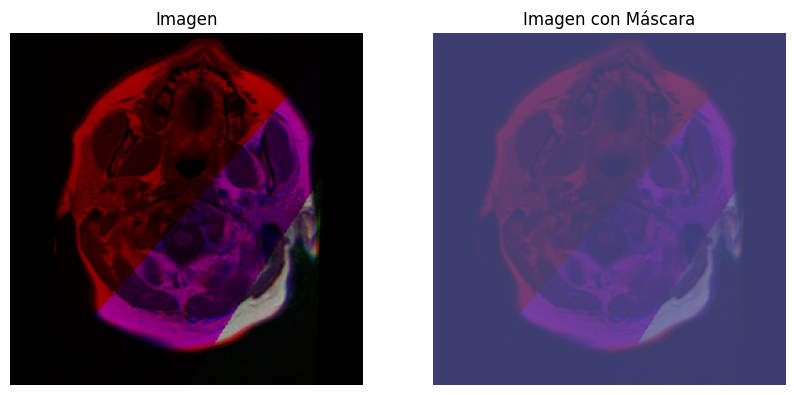

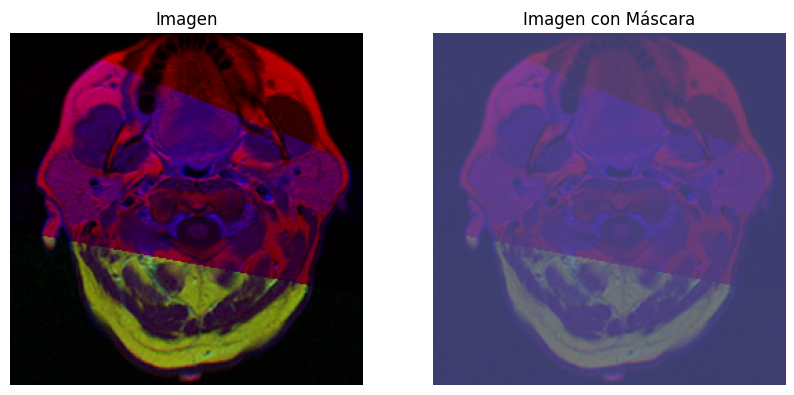

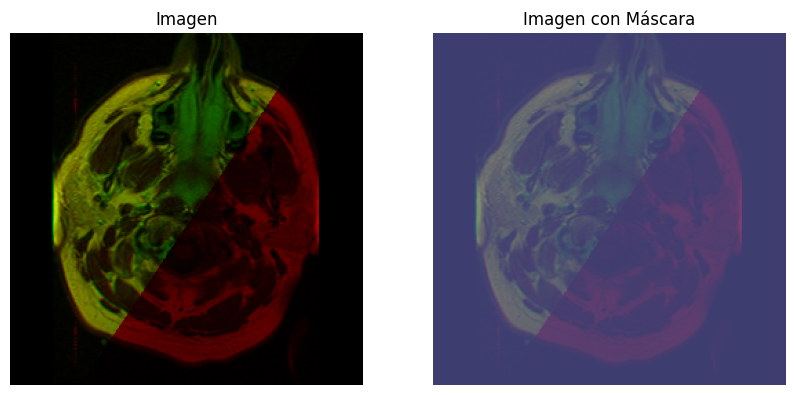

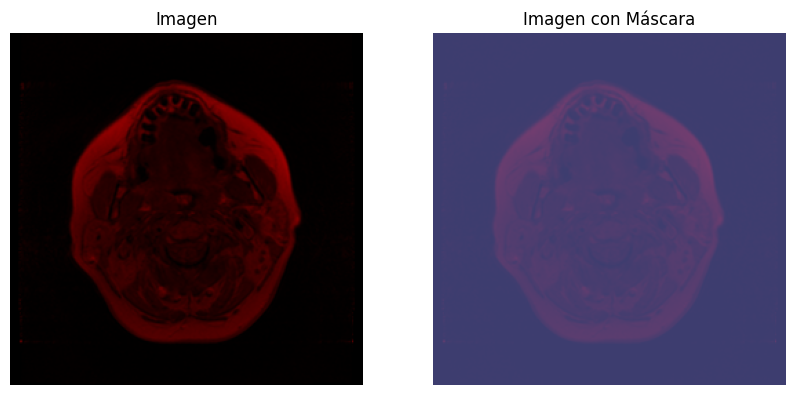

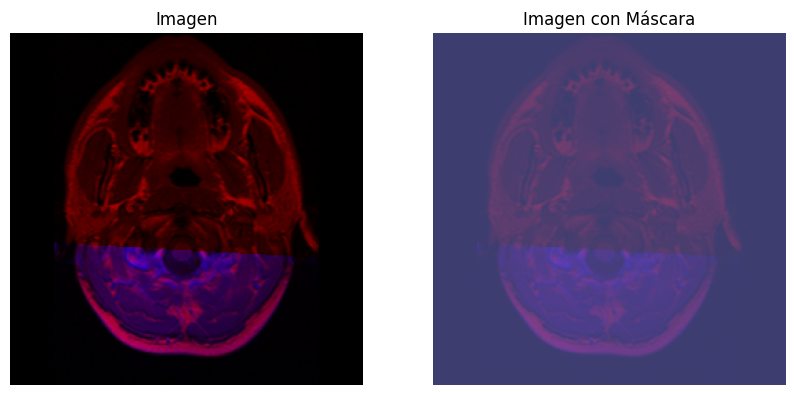

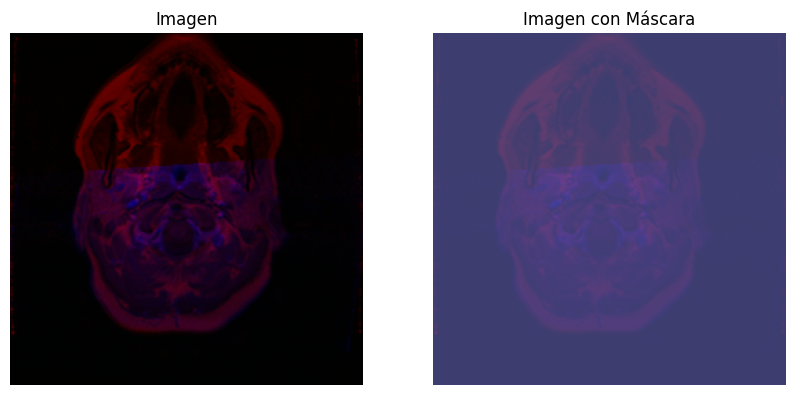

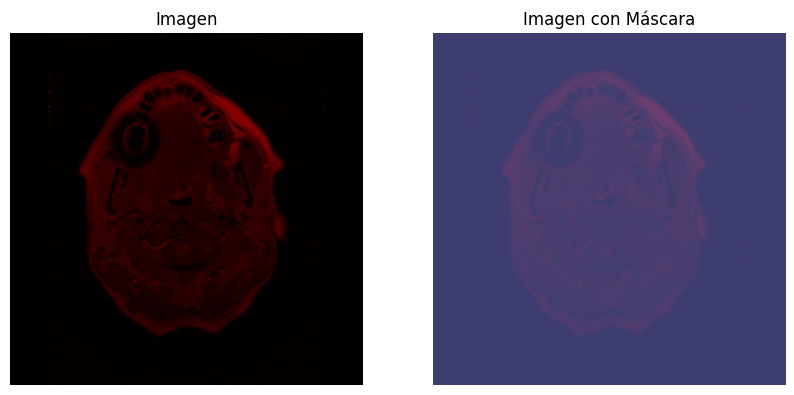

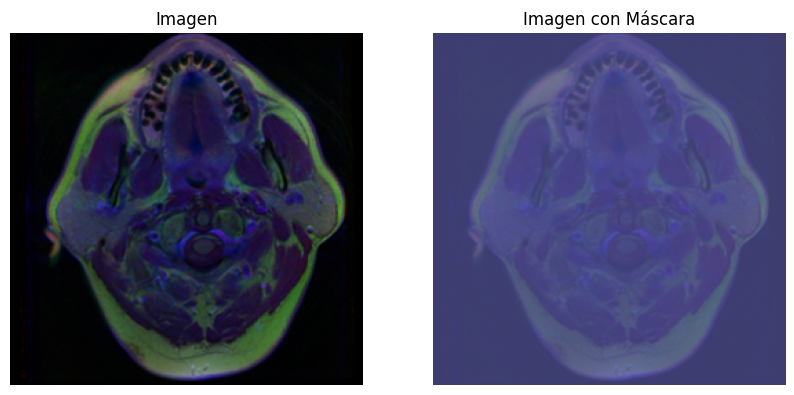

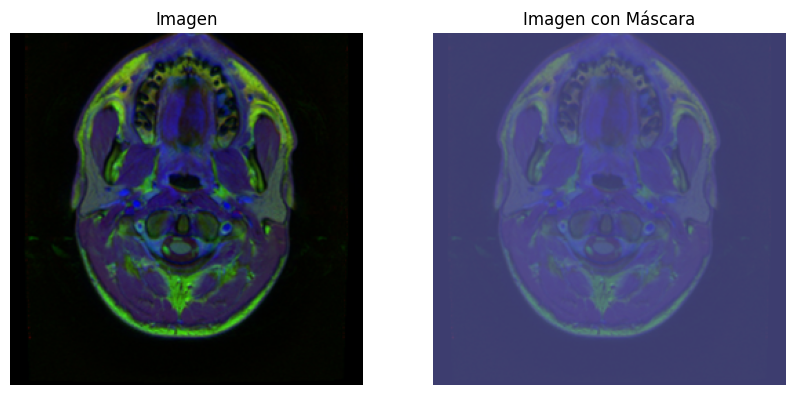

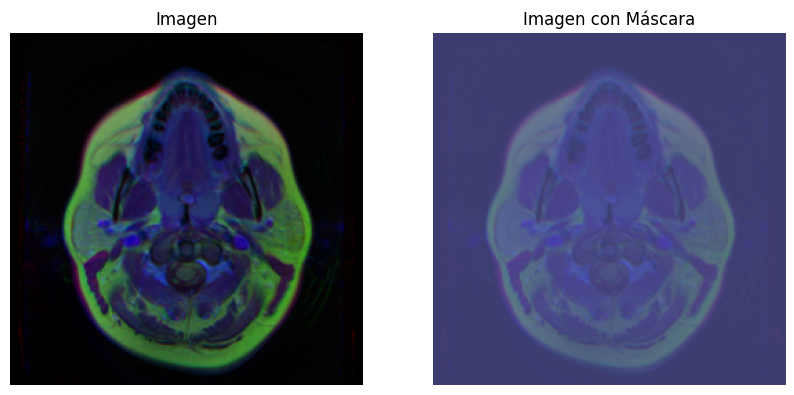

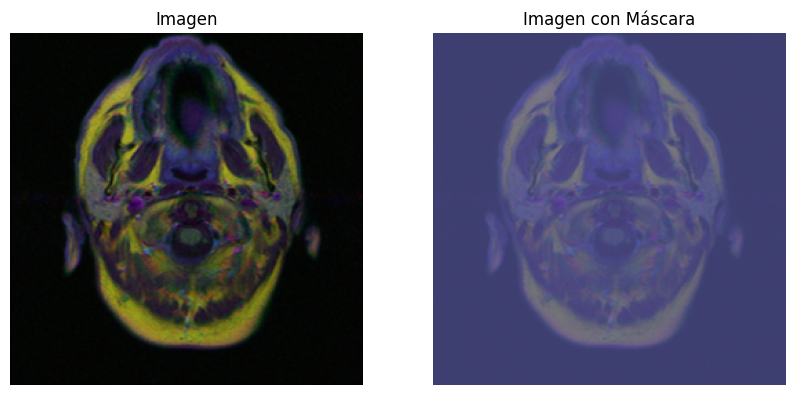

In [7]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import pandas as pd

# Carga las imágenes y máscaras por separado
def load_images_and_masks(dataframe, target_size=(256, 256)):
    images = []
    masks = []

    for _, row in dataframe.iterrows():
        # Cargar imágenes
        image_path = row['image_path']
        img = load_img(image_path, target_size=target_size)
        img_array = img_to_array(img)
        images.append(img_array)

        # Cargar máscaras
        mask_path = row['mask_path']
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, target_size[::-1])  # Invertir el tamaño de destino
        masks.append(mask)

    return np.array(images), np.array(masks)

# Ejemplo de uso:
test_mask = pd.read_csv('test_mask.csv')  # Tu conjunto de datos de prueba (pandas DataFrame) que contiene las columnas 'image_path' y 'mask_path'

# Cargar imágenes y máscaras
images, masks = load_images_and_masks(test_mask)

# Visualizar imágenes y máscaras superpuestas
num_samples = len(images)
for i in range(num_samples):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(images[i]/255.0)  # Mostrar la imagen normalizada entre 0 y 1
    axes[0].set_title('Imagen')
    axes[0].axis('off')
    axes[1].imshow(images[i]/255.0, cmap='gray', alpha=0.6)  # Mostrar la imagen con máscara superpuesta
    axes[1].imshow(masks[i], cmap='jet', alpha=0.4)  # Mostrar la máscara con color map (usando 'jet' como ejemplo)
    axes[1].set_title('Imagen con Máscara')
    axes[1].axis('off')
    plt.show()
